In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

In [ ]:
#do not run again after the directories have been created and saved to drive
dataset_path = '/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
output_path = '/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/organized_data'
test_size = 0.2
random_seed = 42

os.makedirs(os.path.join(output_path, 'benign_train'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'malign_train'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'benign_test'), exist_ok=True)
os.makedirs(os.path.join(output_path, 'malign_test'), exist_ok=True)

def organize_dataset(class_type):
    """Organize images for either benign or malignant class"""
    class_path = os.path.join(dataset_path, class_type)
    all_images = []

    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                img_path = os.path.join(root, file)
                all_images.append(img_path)

    if not all_images:
        print(f"No images found for class: {class_type} in {class_path}")
        return

    train_files, test_files = train_test_split(
        all_images,
        test_size=test_size,
        random_state=random_seed,
        shuffle=True
    )

    for file in train_files:
        shutil.copy(file, os.path.join(output_path, f'{class_type}_train'))

    for file in test_files:
        shutil.copy(file, os.path.join(output_path, f'{class_type}_test'))

organize_dataset('benign')
organize_dataset('malignant')
print("Dataset organized successfully!")

Dataset organized successfully!


In [ ]:
def count_files_in_dir(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

output_path = '/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/organized_data'
output_benign_train = os.path.join(output_path, 'benign_train')
output_malign_train = os.path.join(output_path, 'malignant_train')
output_benign_test = os.path.join(output_path, 'benign_test')
output_malign_test = os.path.join(output_path, 'malignant_test')

print(f"benign_train: {count_files_in_dir(output_benign_train)} files")
print(f"malign_train: {count_files_in_dir(output_malign_train)} files")
print(f"benign_test: {count_files_in_dir(output_benign_test)} files")
print(f"malign_test: {count_files_in_dir(output_malign_test)} files")

benign_train: 1984 files
malign_train: 4351 files
benign_test: 496 files
malign_test: 1088 files


In [5]:
#do not run again, extras already deleted
base_dir = '/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/BreaKHis_v1'

keep_folder = 'organized_data'  #folder to keep

#loop through everything in the base_dir
for item in os.listdir(base_dir):
    item_path = os.path.join(base_dir, item)

    #skip the folder we want to keep
    if item == keep_folder:
        print(f"Keeping: {item_path}")
        continue

    #delete files or folders
    if os.path.isdir(item_path):
        print(f"Deleting folder: {item_path}")
        shutil.rmtree(item_path)
    else:
        print(f"Deleting file: {item_path}")
        os.remove(item_path)

print("Cleanup complete.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/BreaKHis_v1'

In [17]:
!pip install typeguard>=4.0.1

In [19]:
!pip uninstall -y tensorflow-addons

Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa # Removed tensorflow_addons
from keras.applications import imagenet_utils
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import json
import math
import os
import cv2
from PIL import Image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score

tfds.disable_progress_bar()

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype.lower() == ".jpg" or ftype.lower() == ".png": 
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG

benign_train_dir = os.path.join(output_path, 'benign_train')
malign_train_dir = os.path.join(output_path, 'malignant_train')
benign_test_dir = os.path.join(output_path, 'benign_test')
malign_test_dir = os.path.join(output_path, 'malignant_test')


benign_train = np.array(Dataset_loader(benign_train_dir, 224))
malign_train = np.array(Dataset_loader(malign_train_dir, 224))
benign_test = np.array(Dataset_loader(benign_test_dir, 224))
malign_test = np.array(Dataset_loader(malign_test_dir, 224))

100%|██████████| 1088/1088 [00:23<00:00, 46.24it/s]


In [9]:
np.save('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/benign_train.npy', benign_train)
np.save('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/malign_train.npy', malign_train)
np.save('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/benign_test.npy', benign_test)
np.save('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/malign_test.npy', malign_test)

In [ ]:
#labeling, merging, shuffling, and one-hot encoding
benign_train = np.load('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/benign_train.npy')
malign_train = np.load('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/malign_train.npy')
benign_test = np.load('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/benign_test.npy')
malign_test = np.load('/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/malign_test.npy')

#0 for benign, 1 for malignant
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

#merge image data and labels
X_train = np.concatenate((benign_train, malign_train), axis=0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis=0)

X_test = np.concatenate((benign_test, malign_test), axis=0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis=0)

#shuffle training data
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
Y_train = Y_train[train_indices]

#shuffle testing data
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]

#convert labels to categorical
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (6335, 224, 224, 3)
Y_train shape: (6335, 2)
X_test shape: (1584, 224, 224, 3)
Y_test shape: (1584, 2)


In [10]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

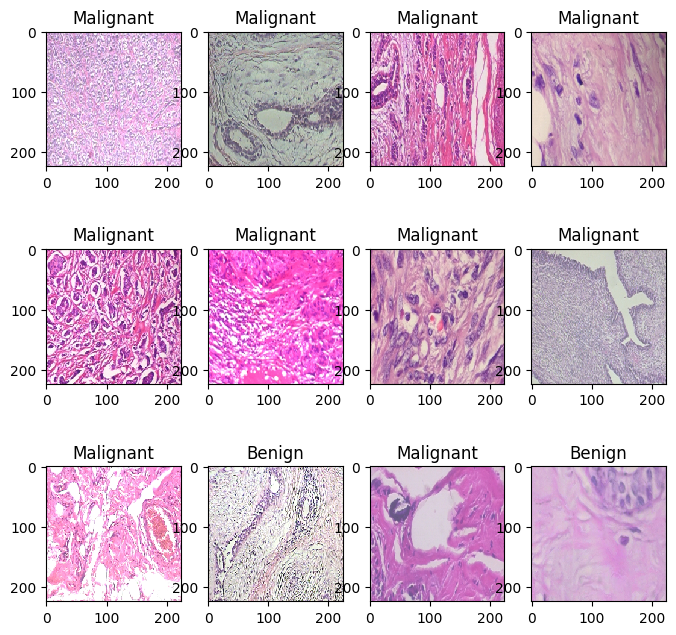

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(8,8))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32
train_generator = ImageDataGenerator(
        zoom_range=2,
         rotation_range = 90,
         horizontal_flip=True,
        vertical_flip=True,
    )

Configure the hyperparameters

In [ ]:
input_shape = (224, 224, 3)
num_classes = 2
learning_rate = 0.001
weight_decay = 0.01
label_smoothing_factor = 0.1

batch_size = 32
num_epochs = 10
image_size = 224 #resize input images to this size
patch_size = 16 #size of the patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
] 
transformer_layers = 8
mlp_head_units = [ 2048, 1024]  #size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [ ]:
#mlp
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [16]:
#patch creation as layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


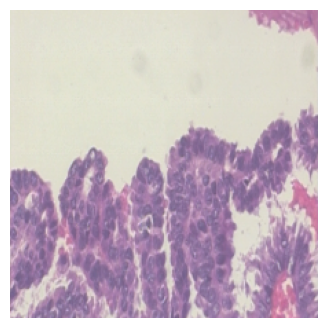

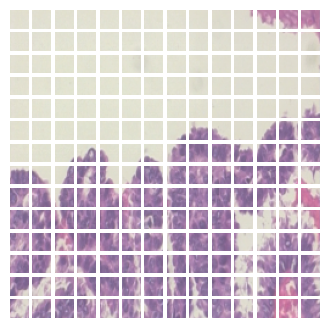

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [ ]:
#creaate a vit model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    #multiple layers of the Transformer block(8)
    for _ in range(transformer_layers):
        
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)   #layer normalization 1
        #multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])
        
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)    #layer normalization 2
        
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        encoded_patches = layers.Add()([x3, x2])

    #[batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    #classify outputs
    logits = layers.Dense(num_classes)(features)
    
    model = keras.Model(inputs=inputs, outputs=logits)
    model.summary()
    return model

In [20]:
from tensorflow.keras.optimizers import Adam, SGD

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow import keras
import time

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          7 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, None, 768) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 64)   │     61,760 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 196, 128)  │          0 │ dense_3[0][0]   

 Total params: 28,519,881 (108.79 MB)

 Trainable params: 28,519,874 (108.79 MB)

 Non-trainable params: 7 (32.00 B)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.7791 - loss: 1.1003 - val_accuracy: 0.8470 - val_loss: 0.3764
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.8166 - loss: 0.4839 - val_accuracy: 0.8360 - val_loss: 0.3644
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.8361 - loss: 0.3886 - val_accuracy: 0.8502 - val_loss: 0.3551
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.8442 - loss: 0.3696 - val_accuracy: 0.8470 - val_loss: 0.3646
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.8513 - loss: 0.3427 - val_accuracy: 0.8628 - val_loss: 0.3129
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.8697 - loss: 0.3101 - val_accuracy: 0.8770 - val_loss: 0.3067
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.8584 - loss: 0.3097 - val_accuracy: 0.8691 - val_loss: 0.3524
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - accuracy: 0.8650 - loss: 0

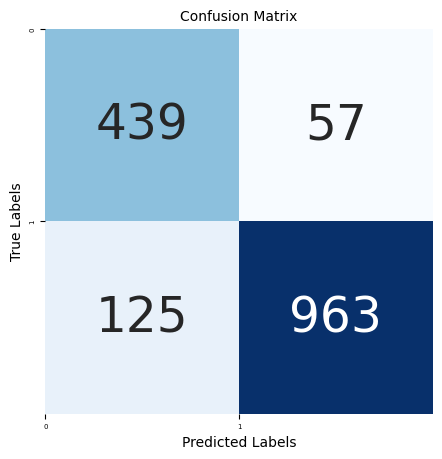

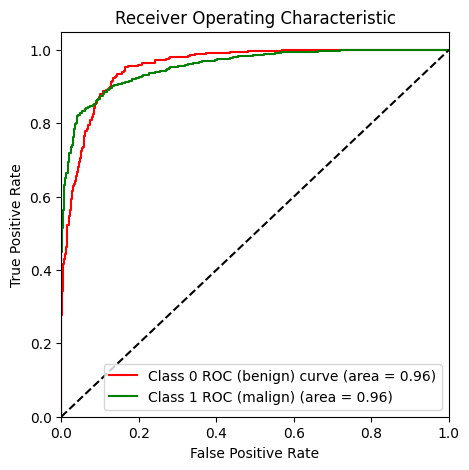

Precision: [0.77836879 0.94411765]
Sensitivity: [0.88508065 0.88511029]
Specificity: [0.88511029 0.88508065]
AUC (Class 0): 0.9558452917457306
AUC (Class 1): 0.9554505900142314
Mean Precision: 0.8612432206925323
Mean Sensitivity: 0.8850954696394687
Mean Specificity: 0.8850954696394687
AUC: 0.9554505900142314
F1 Score: 0.8709820629408185
Mean AUC (Class 0): 0.9558452917457306
Mean AUC (Class 1): 0.9554505900142314


In [ ]:
def run_experiment(model, X_train, Y_train, X_test, Y_test, num_epochs, batch_size, num_classes):
    optimizer = 'AdamaX'

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    checkpoint_filepath = "/content/drive/MyDrive/ibm/BreakHis/BreaKHis_v1/best_model.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    start_time = time.time()
    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    end_time = time.time() 

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    total_training_time = end_time - start_time

    avg_training_time_per_epoch = total_training_time / num_epochs

    print("Total Training Time (s):", total_training_time)
    print("Average Training Time per Epoch (s):", avg_training_time_per_epoch)

    Y_pred = model.predict(X_test)

    cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
    #Precision, Sensitivity, and Specificity
    true_positives = np.diag(cm)
    false_positives = np.sum(cm, axis=0) - true_positives
    false_negatives = np.sum(cm, axis=1) - true_positives
    true_negatives = np.sum(cm) - (true_positives + false_positives + false_negatives)

    precision = true_positives / (true_positives + false_positives)
    sensitivity = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)


    #AUC
    y_test_labels = np.argmax(Y_test, axis=1)
    y_pred_probabilities = Y_pred[:, 1]
    auc = roc_auc_score(y_test_labels, y_pred_probabilities)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

    fpr_0, tpr_0, _ = roc_curve(Y_test[:, 0], Y_pred[:, 0])
    auc_0 = roc_auc_score(Y_test[:, 0], Y_pred[:, 0])

    fpr_1, tpr_1, _ = roc_curve(Y_test[:, 1], Y_pred[:, 1])
    auc_1 = roc_auc_score(Y_test[:, 1], Y_pred[:, 1])

    classes = range(num_classes)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 35})
    plt.title("Confusion Matrix", size=10)
    plt.xlabel("Predicted Labels", size=10)
    plt.ylabel("True Labels", size=10)
    plt.xticks(ticks=classes, labels=classes, size=5)
    plt.yticks(ticks=classes, labels=classes, size=5)
    plt.show()

    plt.figure(figsize=(5,5))
    plt.plot(fpr_0, tpr_0, color='red', label='Class 0 ROC (benign) curve (area = %0.2f)' % auc_0)
    plt.plot(fpr_1, tpr_1, color='green', label='Class 1 ROC (malign) (area = %0.2f)' % auc_1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("AUC (Class 0):", auc_0)
    print("AUC (Class 1):", auc_1)

    print("Mean Precision:", np.mean(precision))
    print("Mean Sensitivity:", np.mean(sensitivity))
    print("Mean Specificity:", np.mean(specificity))
    print("AUC:", np.mean(auc))
    print("F1 Score:", np.mean(f1))

    print("Mean AUC (Class 0):", np.mean(auc_0))
    print("Mean AUC (Class 1):", np.mean(auc_1))



    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier, X_train, Y_train, X_test, Y_test, num_epochs, batch_size, num_classes)

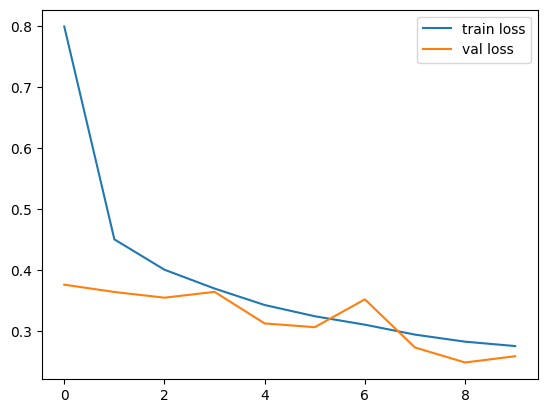

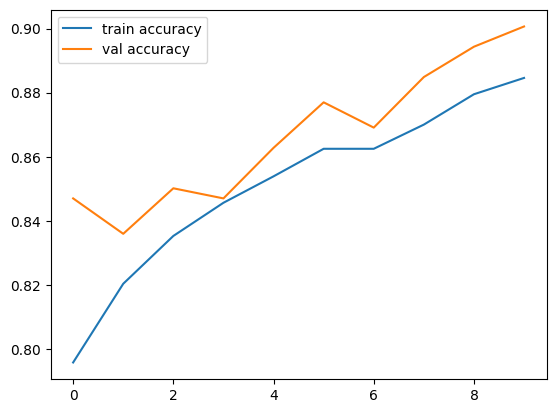

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_accuracy')

Saving SOB_M_LC-14-15570-200-031.png to SOB_M_LC-14-15570-200-031.png
User uploaded file "SOB_M_LC-14-15570-200-031.png" with length 421376 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Malignant


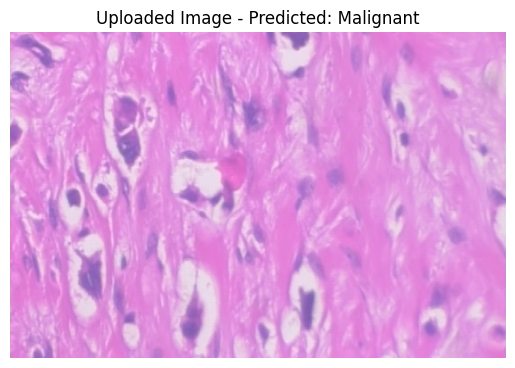

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, target_size):
    """Loads an image from path and preprocesses it for the model."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array

def predict_uploaded_image(model, target_size=(224, 224)):
    """Allows user to upload an image and get a prediction from the model."""
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

        img_array = load_and_preprocess_image(fn, target_size)

        predictions = model.predict(img_array)

        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions, axis=1)[0]

        class_names = ['Benign', 'Malignant']
        predicted_class_name = class_names[predicted_class_index]

        print(f"Prediction: {predicted_class_name}")

        img = Image.open(fn)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Uploaded Image - Predicted: {predicted_class_name}')
        plt.show()

predict_uploaded_image(vit_classifier, target_size=(224, 224))
